Crear un modelo de Sugeno del comportamiento de un diodo, para lo cual se ha medido la tensión en sus bornes y la
corriente que lo atraviesa. Los datos obtenidos se encuentran en el archivo diodo.txt. El modelo logrado deberá tener no
más de dos reglas.

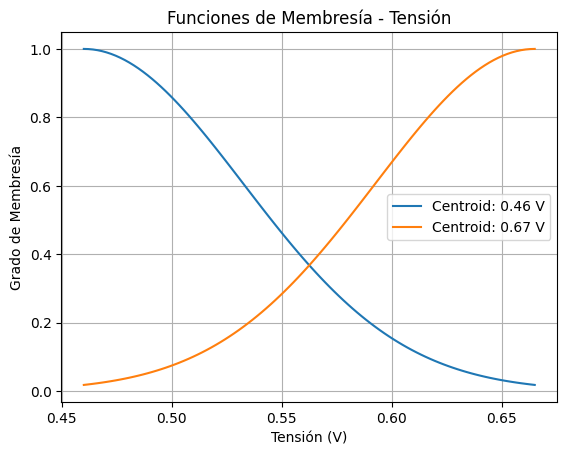

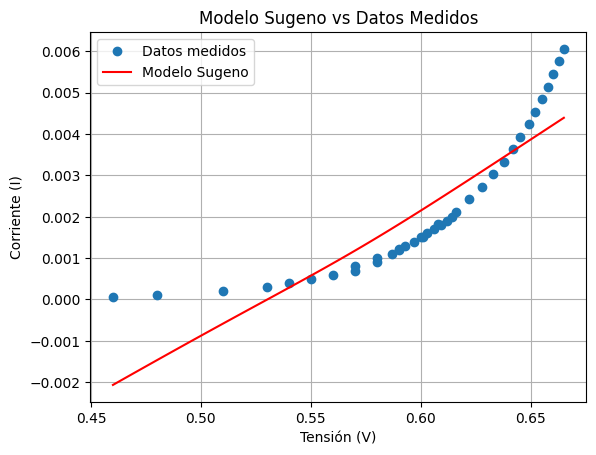

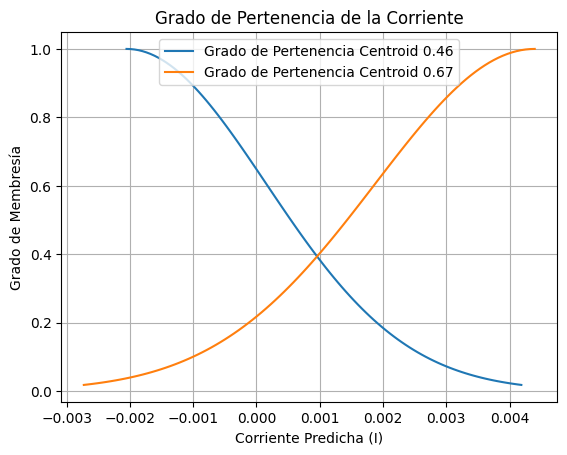

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class SugenoRule:
    def __init__(self, centroid, output_model):
        self.centroid = centroid
        self.output_model = output_model

    def evaluate(self, tension):
        return self.output_model.predict(np.array([[tension]]))[0]

class SugenoInput:
    def __init__(self, min_val, max_val, centroids):
        self.minValue = min_val
        self.maxValue = max_val
        self.centroids = centroids

    def view(self):
        x = np.linspace(self.minValue, self.maxValue, 100)
        plt.figure()
        for m in self.centroids:
            sigma = (self.maxValue - self.minValue) / np.sqrt(8)
            y = gaussmf(x, m, sigma)
            plt.plot(x, y, label=f'Centroid: {m:.2f} V')
        plt.title('Funciones de Membresía - Tensión')
        plt.xlabel('Tensión (V)')
        plt.ylabel('Grado de Membresía')
        plt.legend()
        plt.grid(True)
        plt.show()

class SugenoFIS:
    def __init__(self):
        self.rules = []
        self.inputs = []

    def genfis(self, data):
        num_clusters = 2
        centroids = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), num_clusters)
        min_val = np.min(data[:, 0])
        max_val = np.max(data[:, 0])

        self.inputs = [SugenoInput(min_val, max_val, centroids)]

        models = []
        for i in range(num_clusters):
            if i == 0:
                region = data[data[:, 0] <= centroids[i + 1]]
            else:
                region = data[data[:, 0] > centroids[i - 1]]

            model = LinearRegression().fit(region[:, 0].reshape(-1, 1), region[:, 1])
            models.append(model)

        self.rules = [
            SugenoRule(centroids[0], models[0]),
            SugenoRule(centroids[1], models[1])
        ]

    def evalfis(self, tension):
        sigma = (self.inputs[0].maxValue - self.inputs[0].minValue) / np.sqrt(8)
        memberships = np.array([gaussmf(tension, rule.centroid, sigma) for rule in self.rules])
        weighted_outputs = np.array([rule.evaluate(tension) * membership for rule, membership in zip(self.rules, memberships)])
        return np.sum(weighted_outputs) / np.sum(memberships)

    def viewInputs(self):
        for input in self.inputs:
            input.view()

    def viewMemberships(self, tension_test):
        sigma = (self.inputs[0].maxValue - self.inputs[0].minValue) / np.sqrt(8)
        memberships = np.array([gaussmf(tension_test, rule.centroid, sigma) for rule in self.rules])

        plt.figure()
        for i, membership in enumerate(memberships):
            plt.plot(tension_test, membership, label=f'Membresía Centroid {self.rules[i].centroid:.2f}')
        plt.title('Grado de Pertenencia de la Tensión')
        plt.xlabel('Tensión (V)')
        plt.ylabel('Grado de Membresía')
        plt.legend()
        plt.grid(True)
        plt.show()

# Cargar los datos directamente
data = np.loadtxt('diodo.txt')

# Separar las columnas de tensión y corriente
tension = data[:, 0]
corriente = data[:, 1]

# Crear el modelo Sugeno
sugeno = SugenoFIS()
sugeno.genfis(data)

# Verificar las funciones de membresía
sugeno.viewInputs()

# Evaluar el modelo
tension_test = np.linspace(np.min(tension), np.max(tension), 100)
corriente_pred = np.array([sugeno.evalfis(t) for t in tension_test])

# Verificar dimensiones
if tension_test.shape[0] != corriente_pred.shape[0]:
    raise ValueError("Las dimensiones de tensión de prueba y corriente predicha no coinciden.")

# Graficar resultados
plt.figure()
plt.plot(tension, corriente, 'o', label='Datos medidos')
plt.plot(tension_test, corriente_pred, label='Modelo Sugeno', color='red')
plt.xlabel('Tensión (V)')
plt.ylabel('Corriente (I)')
plt.title('Modelo Sugeno vs Datos Medidos')
plt.legend()
plt.grid(True)
plt.show()

# Graficar grados de pertenencia de la corriente
plt.figure()
for rule in sugeno.rules:
    sigma = (sugeno.inputs[0].maxValue - sugeno.inputs[0].minValue) / np.sqrt(8)
    membership = gaussmf(tension_test, rule.centroid, sigma)
    pred_corriente = np.array([rule.evaluate(t) for t in tension_test])
    plt.plot(pred_corriente, membership, label=f'Grado de Pertenencia Centroid {rule.centroid:.2f}')
plt.title('Grado de Pertenencia de la Corriente')
plt.xlabel('Corriente Predicha (I)')
plt.ylabel('Grado de Membresía')
plt.legend()
plt.grid(True)
plt.show()



El primer grafico muestra las funciones de membresía para la tensión.

El segundo grafico compara los datos medidos con la salida del modelo Sugeno para evaluar cómo bien el modelo se ajusta a los datos reales.

El tercer grafico muestra las funciones de membrecia de la corriente en función de la corriente predicha por el modelo Sugeno